In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/cleaned_train1.csv")
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (16208, 22)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,sale_year,sale_month,house_age,is_renovated,log_price
0,268643,4,2.25,1810,9240,2.0,0,0,3,7,...,98055,47.4362,-122.187,1660,9240,2015,5,54,0,12.501142
1,245000,3,2.50,1600,2788,2.0,0,0,4,7,...,98031,47.4034,-122.187,1720,3605,2014,7,22,0,12.409018
2,200000,4,2.50,1720,8638,2.0,0,0,3,8,...,98003,47.2704,-122.313,1870,7455,2015,1,21,0,12.206078
3,352499,2,2.25,1240,705,2.0,0,0,3,7,...,98027,47.5321,-122.073,1240,750,2015,4,6,0,12.772806
4,232000,3,2.00,1280,13356,1.0,0,0,3,7,...,98042,47.3715,-122.074,1590,8071,2014,12,20,0,12.354497


Load the images to the local disk in google colab for faster access

In [3]:
import shutil, os
from tqdm import tqdm

LOCAL_IMG_FOLDER = "/content/local_images"
DRIVE_IMG_FOLDER = "/content/drive/MyDrive/sat_img_train_data"

os.makedirs(LOCAL_IMG_FOLDER, exist_ok=True)

files = [f for f in os.listdir(DRIVE_IMG_FOLDER) if f.endswith(".jpg")]

print("Copying images to fast disk...")
for f in tqdm(files):
    shutil.copy(os.path.join(DRIVE_IMG_FOLDER, f),
                os.path.join(LOCAL_IMG_FOLDER, f))

print("Images copied:", len(files))


Copying images to fast disk...


100%|██████████| 16208/16208 [05:13<00:00, 51.75it/s] 

Images copied: 16208


Map images to the corresponding data sample

In [4]:
import os
import re

IMG_DIR = "/content/local_images"

# Get all available house_XXX.jpg files
img_files = [f for f in os.listdir(IMG_DIR) if f.startswith("house_") and f.endswith(".jpg")]

# Sort numerically by index
img_files = sorted(img_files, key=lambda x: int(re.findall(r"\d+", x)[0]))

print("Total images found:", len(img_files))


Total images found: 16208


In [5]:
# We assume df is already loaded and in correct order
assert len(img_files) >= len(df), "Not enough images to map all rows!"

df["image_path"] = [os.path.join(IMG_DIR, img_files[i]) for i in range(len(df))]


In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os


In [7]:
print(df.shape)

(16208, 23)


In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


ResNet50 Feature Extractor with Grad-CAM Support

Define a custom ResNet50 model to extract image features and retain gradients for Grad-CAM interpretability. This allows visualization of which regions of satellite images contribute most to predictions.

In [19]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet50_CAM(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        self.conv1 = base.conv1
        self.bn1 = base.bn1
        self.relu = base.relu
        self.maxpool = base.maxpool
        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4
        self.avgpool = base.avgpool

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        self.feature_maps = self.layer4(x)
        self.feature_maps.retain_grad()

        x = self.avgpool(self.feature_maps)
        x = torch.flatten(x, 1)
        return x


In [20]:
cnn = ResNet50_CAM().to(device)
cnn.eval()


ResNet50_CAM(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

Custom Dataset for Satellite Images

Create a PyTorch Dataset to load and preprocess satellite images corresponding to each house. Images are transformed to match the input requirements of the ResNet50 model.

In [23]:
class ImageDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = Image.open(self.df.iloc[idx]["image_path"]).convert("RGB")
        return self.transform(img)


Image Preprocessing

Define transformations to resize images to 224×224, convert them to tensors, and normalize using ImageNet statistics for ResNet50 input.

In [24]:
extract_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])


Feature Extraction from Images

Load images in batches, pass them through the CNN, and extract deep features from the final layer to create a feature matrix for each house

In [ ]:
dataset = ImageDataset(df, extract_transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

features = []

with torch.no_grad():
    for imgs in loader:
        imgs = imgs.to(device)
        feats = cnn(imgs)
        features.append(feats.cpu().numpy())

raw_image_features = np.vstack(features)
print("Raw image feature shape:", raw_image_features.shape)


Raw image feature shape: (16208, 2048)


Dimensionality Reduction with PCA

Compress the high-dimensional CNN image features into 50 principal components while preserving most of the variance.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
visual_features = pca.fit_transform(raw_image_features)

print("PCA visual features:", visual_features.shape)
print("Variance captured:", pca.explained_variance_ratio_.sum())


PCA visual features: (16208, 50)
Variance captured: 0.7815659


Tabular Feature Preparation

Encode categorical fields, remove leakage columns, and extract numerical features and log-price targets for model training.

In [ ]:
df_clean = df.copy()

# Encode zipcode (XGBoost needs numeric)
df_clean["zipcode"] = df_clean["zipcode"].astype("category").cat.codes

# Drop leakage columns
drop_cols = ["price", "log_price", "image_path"]
tabular_cols = [c for c in df_clean.columns if c not in drop_cols]

tabular_features = df[tabular_cols].values.astype("float32")

# Use LOG price for training (better stability)
y = df["log_price"].values.astype("float32")

print("Final aligned samples:", len(df))
print("Tabular shape:", tabular_features.shape)
print("Target shape:", y.shape)



Final aligned samples: 16208
Tabular shape: (16208, 20)
Target shape: (16208,)


stack both img data and tabular data to form final input data

In [ ]:
X = np.hstack([tabular_features, visual_features])
print("Final X shape:", X.shape)


Final X shape: (16208, 70)


split data for train and test

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


initialize the xgboost model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score

xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)


xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)


[0]	validation_0-rmse:0.50132
[100]	validation_0-rmse:0.17319
[200]	validation_0-rmse:0.16862
[300]	validation_0-rmse:0.16690
[400]	validation_0-rmse:0.16661
[420]	validation_0-rmse:0.16666


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

testing the trained model and find metrics

In [ ]:
# Predict in log-space
preds_log = xgb_model.predict(X_test)

# Convert back to real prices
preds_price = np.expm1(preds_log)
y_test_price = np.expm1(y_test)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_price, preds_price)
rmse = np.sqrt(mean_squared_error(y_test_price, preds_price))
r2 = r2_score(y_test_price, preds_price)

print("\nFinal Multimodal Model (Tabular + Satellite Images)")
print(f"MAE:  ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R²:   {r2:.4f}")



Final Multimodal Model (Tabular + Satellite Images)
MAE:  $63,709
RMSE: $111,236
R²:   0.8898


Visualise results

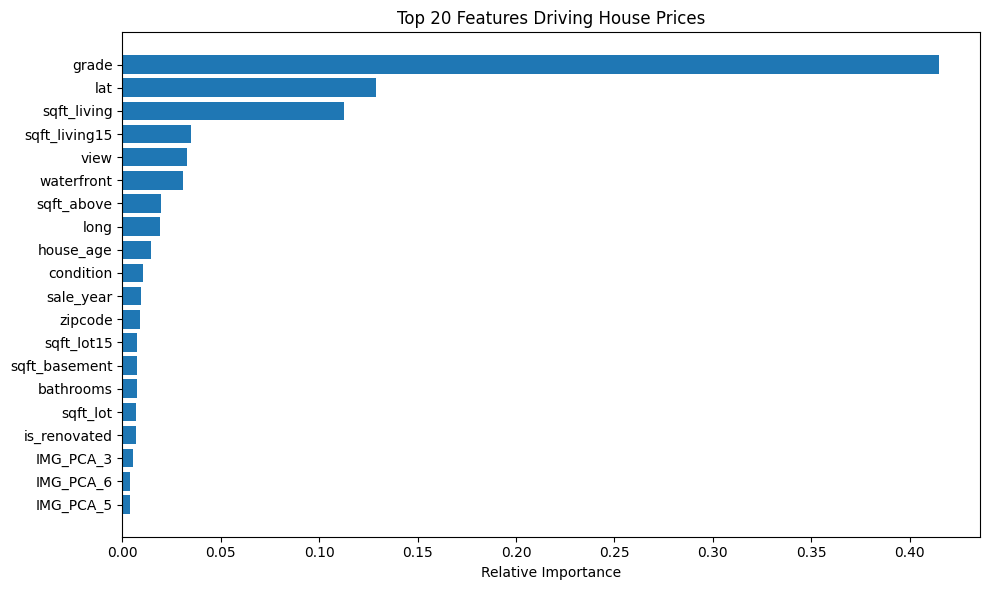

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get importance scores
importance = xgb_model.feature_importances_

# Make sure feature names align with X
n_pca = visual_features.shape[1]   # safer than hardcoding 50
feature_names = tabular_cols + [f"IMG_PCA_{i+1}" for i in range(n_pca)]

assert len(feature_names) == len(importance), "Feature name mismatch!"

# Sort top 20 features
top_k = 20
ids = np.argsort(importance)[::-1][:top_k]

top_feats = [feature_names[i] for i in ids]
top_scores = importance[ids]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_feats[::-1], top_scores[::-1])   # reverse for correct ordering
plt.title("Top 20 Features Driving House Prices")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()


In [ ]:
import shap

# Sample 1000 rows for SHAP (enough for stability)
idx = np.random.choice(len(X_train), 1000, replace=False)
X_shap = X_train[idx]


In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_shap)


In [ ]:
n_pca = visual_features.shape[1]
feature_names = tabular_cols + [f"IMG_PCA_{i+1}" for i in range(n_pca)]


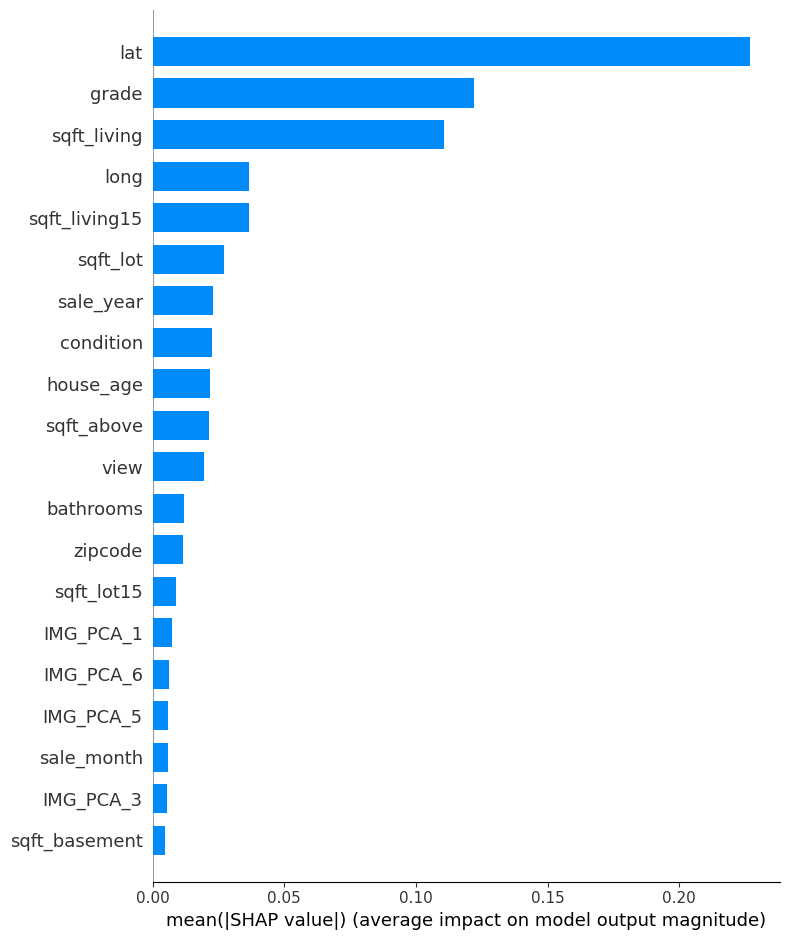

In [ ]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    plot_type="bar"
)


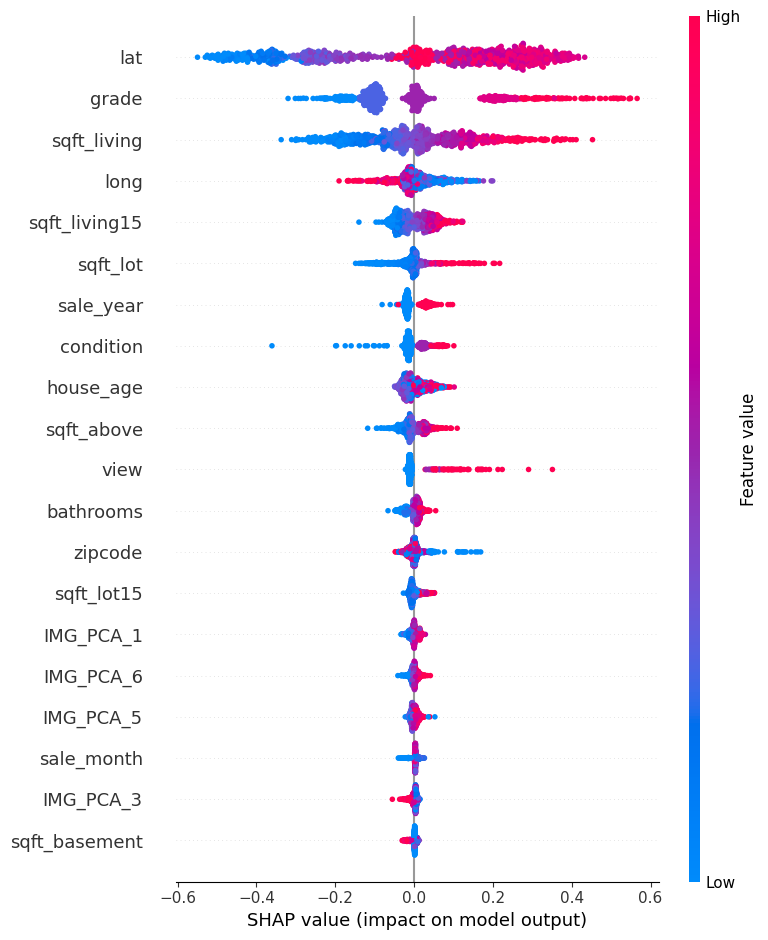

In [ ]:
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names
)


In [ ]:
image_indices = [i for i, f in enumerate(feature_names) if f.startswith("IMG_PCA")]
tabular_indices = [i for i, f in enumerate(feature_names) if not f.startswith("IMG_PCA")]

img_contribution = np.abs(shap_values[:, image_indices]).mean()
tab_contribution = np.abs(shap_values[:, tabular_indices]).mean()

print("Satellite Image Contribution:", round(img_contribution / (img_contribution + tab_contribution) * 100, 2), "%")
print("Tabular Contribution:", round(tab_contribution / (img_contribution + tab_contribution) * 100, 2), "%")


Satellite Image Contribution: 5.82 %
Tabular Contribution: 94.18 %


In [ ]:
# Predict log(price)
log_preds = xgb_model.predict(X_test)

# Convert back to actual price
price_preds_er = np.expm1(log_preds)
price_true_er  = np.expm1(y_test)

errors = price_preds_er - price_true_er
abs_errors = np.abs(errors)
pct_errors = 100 * errors / price_true_er


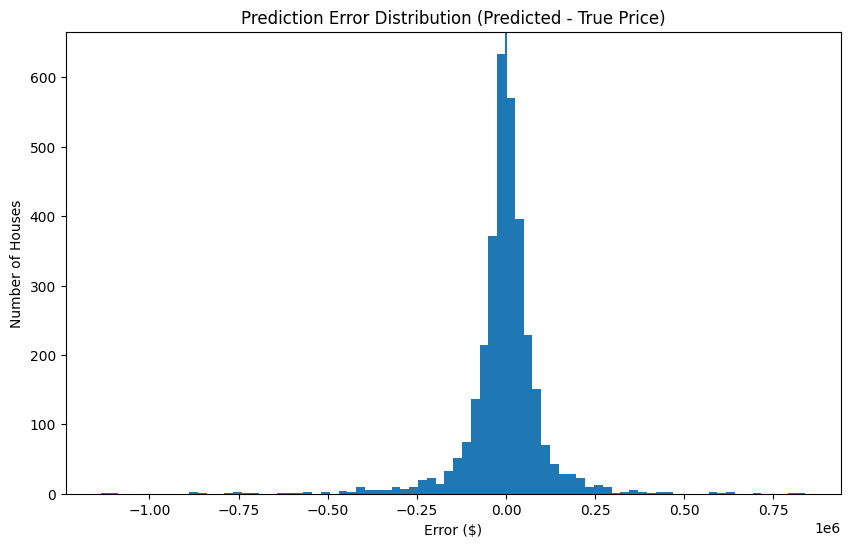

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(errors, bins=80)
plt.axvline(0)
plt.title("Prediction Error Distribution (Predicted - True Price)")
plt.xlabel("Error ($)")
plt.ylabel("Number of Houses")
plt.show()


Grad cam for interpretability of model

In [27]:
import cv2
import numpy as np

def compute_gradcam(model, img_tensor):
    model.zero_grad()

    # Forward
    output = model(img_tensor)

    # Pick strongest neuron
    score = output.max()

    # Backprop
    score.backward()

    # Get gradients from last conv layer
    gradients = model.feature_maps.grad
    activations = model.feature_maps

    # Global average pooling of gradients
    weights = gradients.mean(dim=(2,3), keepdim=True)

    cam = (weights * activations).sum(dim=1)
    cam = torch.relu(cam)

    cam = cam.squeeze().detach().cpu().numpy()

    # Normalize
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    return cam


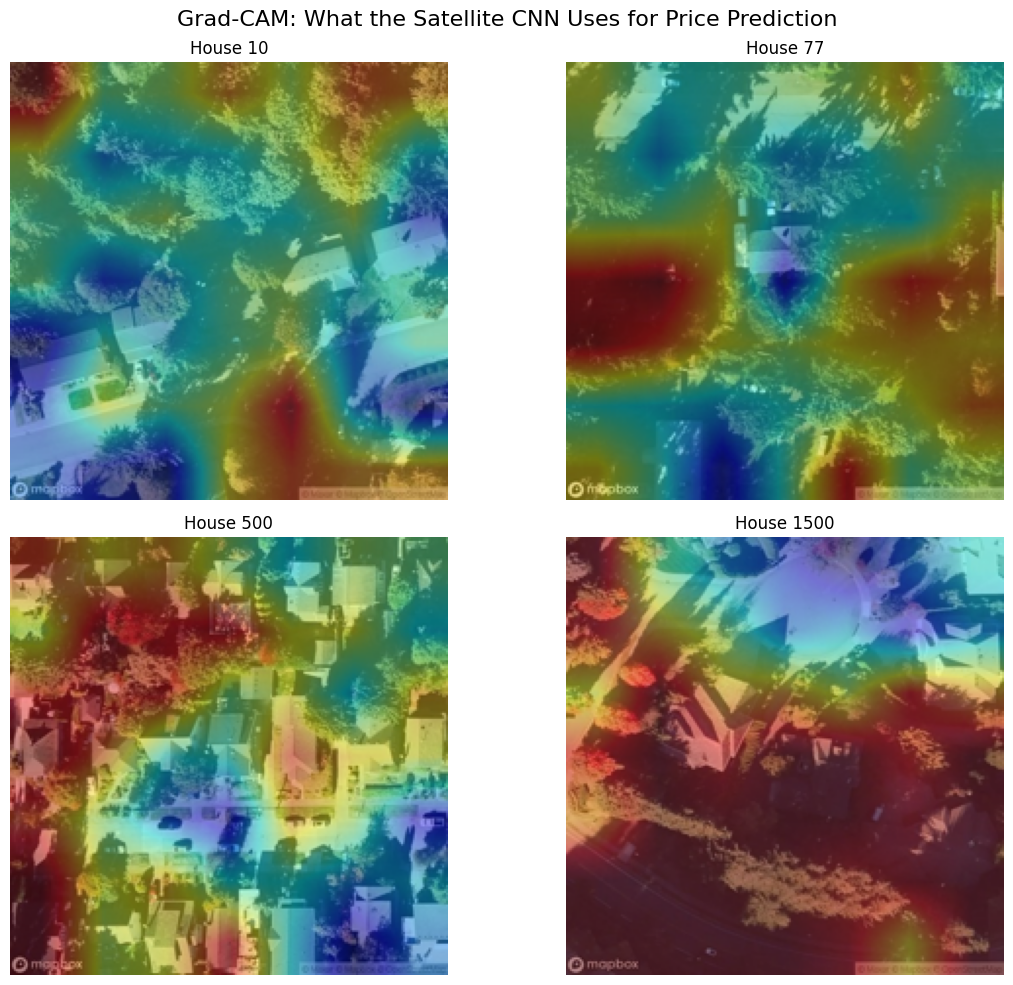

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

indices = [10, 77, 500, 1500]   # pick any 4 house indices

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices):
    img_path = df.iloc[idx]["image_path"]
    img = Image.open(img_path).convert("RGB")

    img_tensor = extract_transform(img).unsqueeze(0).to(device)
    img_tensor.requires_grad_()

    cam = compute_gradcam(cnn, img_tensor)

    # Resize CAM to image size
    cam_resized = cv2.resize(cam, (224,224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    orig = np.array(img.resize((224,224)))
    overlay = 0.4 * heatmap + 0.6 * orig

    # Plot
    plt.subplot(2, 2, i+1)
    plt.imshow(overlay.astype(np.uint8))
    plt.title(f"House {idx}")
    plt.axis("off")

plt.suptitle("Grad-CAM: What the Satellite CNN Uses for Price Prediction", fontsize=16)
plt.tight_layout()
plt.show()


Now apply the trained model on test data to get results

In [ ]:
import shutil, os
from tqdm import tqdm

#  Define fast local folder for test images
LOCAL_TEST_IMG_FOLDER = "/content/local_test_images"
DRIVE_TEST_IMG_FOLDER = "/content/drive/MyDrive/sat_img_test_data"  # update with your test folder path

os.makedirs(LOCAL_TEST_IMG_FOLDER, exist_ok=True)

# List all test images
files = [f for f in os.listdir(DRIVE_TEST_IMG_FOLDER) if f.endswith(".jpg")]

print(f"Copying {len(files)} test images to fast disk...")

# Copy loop
for f in tqdm(files):
    shutil.copy(
        os.path.join(DRIVE_TEST_IMG_FOLDER, f),
        os.path.join(LOCAL_TEST_IMG_FOLDER, f)
    )

print("Test images copied:", len(files))


Copying 5404 test images to fast disk...


100%|██████████| 5404/5404 [02:49<00:00, 31.91it/s] 

Test images copied: 5404


preprocess test data

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# LOAD TEST CSV 
test_df = pd.read_csv("/content/test2_data1.csv")  # update path

#  STEP 1: HANDLE DATES 
test_df['date'] = pd.to_datetime(test_df['date'], errors='coerce')
test_df['sale_year'] = test_df['date'].dt.year.fillna(0).astype(int)
test_df['sale_month'] = test_df['date'].dt.month.fillna(0).astype(int)
test_df = test_df.drop(['date'], axis=1)

#  STEP 2: FEATURE ENGINEERING 
test_df['house_age'] = test_df['sale_year'] - test_df.get('yr_built', 0)
test_df['is_renovated'] = (test_df.get('yr_renovated', 0) > 0).astype(int)

# Drop original columns if exist
for col in ['yr_built', 'yr_renovated']:
    if col in test_df.columns:
        test_df = test_df.drop([col], axis=1)

#  STEP 3: HANDLE CATEGORICALS
test_df['zipcode'] = test_df['zipcode'].astype('category').cat.codes

# STEP 4: MISSING VALUES 
# Fill numeric columns with median
numeric_cols = test_df.select_dtypes(include=np.number).columns.tolist()
for col in numeric_cols:
    test_df[col] = test_df[col].fillna(test_df[col].median())

# Fill categorical columns with mode
cat_cols = test_df.select_dtypes(include='category').columns.tolist()
for col in cat_cols:
    test_df[col] = test_df[col].fillna(test_df[col].mode()[0])

# STEP 5: PREPARE TABULAR FEATURES
train_tab_cols = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors',
                  'waterfront','view','condition','grade','sqft_above','sqft_basement',
                  'zipcode','lat','long','sqft_living15','sqft_lot15',
                  'sale_year','sale_month','house_age','is_renovated']

# Fill missing columns in test_df if any
for col in train_tab_cols:
    if col not in test_df.columns:
        test_df[col] = 0

test_tabular = test_df[train_tab_cols].values.astype('float32')
print("Test tabular features shape:", test_tabular.shape)

Using device: cpu
Test tabular features shape: (5404, 20)


In [ ]:
# CNN dataset for test images
class TestImageDataset(Dataset):
    def __init__(self, n_samples, transform=None):
        self.n_samples = n_samples
        self.transform = transform

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # Use index-based naming: test_house_0.jpg, test_house_1.jpg, ...
        img_path = os.path.join(LOCAL_TEST_IMG_FOLDER, f"test_house_{idx}.jpg")
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except Exception:
            # fallback to blank image if missing
            img = torch.zeros((3, 224, 224))
        return img

# Transform (same as training)
extract_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_dataset = TestImageDataset(len(test_df), transform=extract_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Feature extractor (same as training)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.eval()
all_test_feats = []

with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        feats = cnn(imgs)  # (B, 2048)
        all_test_feats.append(feats.cpu().numpy())

test_raw_image_features = np.vstack(all_test_feats)
print("Test raw image features shape:", test_raw_image_features.shape)


Test raw image features shape: (5404, 2048)


In [ ]:
# Compress features with the same PCA object used in training
test_image_pca = pca.transform(test_raw_image_features)
print("Test PCA image features shape:", test_image_pca.shape)


Test PCA image features shape: (5404, 50)


In [ ]:
X_test_final = np.hstack([test_tabular, test_image_pca])
print("Final test feature matrix shape:", X_test_final.shape)


Final test feature matrix shape: (5404, 70)


In [ ]:

test_preds_log = xgb_model.predict(X_test_final)
test_preds_price = np.expm1(test_preds_log)  # convert back from log


Final results

In [ ]:
# Combine with test IDs
output_df = pd.DataFrame({
    "id": test_df["id"],
    "predicted_price": test_preds_price
})

# Save
output_df.to_csv("test_predictions.csv", index=False)
output_df.to_excel("test_predictions.xlsx", index=False)

print("Predictions saved to CSV and Excel!")


Predictions saved to CSV and Excel!
